# Adaptive Langevin

\begin{align*}
dq &= p dt, \\
dp &= \tilde{F}(q) \, dt - \xi p \, dt + \sigma_A dW_A, \\
d\xi &= \mu^{-1} \left[ p^T p - N_d k_B T \right] dt.
\end{align*}

In [28]:
# using LaTeXStrings, Random, Plots, Serialization, StatsBase, Base.Threads, LinearAlgebra, Distributions, PlotUtils
using LinearAlgebra, Plots, StatsBase, Serialization, Distributions, StableDistributions, LaTeXStrings, SpecialFunctions, Integrals

include("AdL.jl"); include("force.jl"); include("Ad2L.jl"); 

In [65]:
q_force = force_V; q_pot = pot_V; q_monitor = omega; q_monitor_prime = omega_prime
# q_force = force_mho; q_pot = pot_mho; q_monitor = monitor_mho; q_monitor_prime = monitor_prime_mho
q0 = randn(1); p0 = randn(1); xi0 = randn()
t = 100000; h = .1; Nsteps = round(Int, t/h); idx = round(Int, 0.2 * Nsteps) + 1; m = 0.1; M = 1.1
sigma_A = 1.0; mu = 1; beta = 1.0; Nd = 1.; γ = 1.0; beta = 1.0
noise1 = noise2 = nothing

q_traj = zeros(eltype(q0), (size(q0)..., Nsteps));
s_avg1 = zeros(Nsteps)
q = copy(q0); p = copy(p0)
xi = copy(γ); sigma_A = sqrt(2*γ*beta^(-1))
force = q_force(q)
tmp = mean(q_monitor(q)); g = psi(tmp, m, M); g_prime = psi_prime(tmp, m, M) * q_monitor_prime(q)

for i in 1:Nsteps
    p = B_step_hat(q, p, xi, h/2, g, g_prime, force, beta)
    q, s = A_step_hat(q, p, xi, h/2, g, g_prime, count=true, tol=1e-16); s_avg1[i] += s
    tmp = mean(q_monitor(q)); g = psi(tmp, m, M);  # BAOAB step with Ad Stepsize
    p = O_step_hat(q, p, xi, h, g, g_prime, sigma_A)
    q, s = A_step_hat(q, p, xi, h/2, g, g_prime, count=true, tol=1e-16); s_avg1[i] += s
    tmp = mean(q_monitor(q)); g = psi(tmp, m, M); g_prime = psi_prime(tmp, m, M) * q_monitor_prime(q)  # BAOAB step with Ad Stepsize
    if noise1 === nothing
        force = q_force(q)
    elseif noise2 === nothing
        force = q_force(q) + rand(noise1, dim)
    else
        force = q_force(q) + rand(noise1, dim) + rand(noise2, dim)
    end
    p = B_step_hat(q, p, xi, h/2, g, g_prime, force, beta)

    q_traj[:,i] = q
    # p_traj[:,i] = p
end

s_avg1 = s_avg1 / 2;

In [82]:
q_force = force_V; q_pot = pot_V; q_monitor = omega; q_monitor_prime = omega_prime
# q_force = force_mho; q_pot = pot_mho; q_monitor = monitor_mho; q_monitor_prime = monitor_prime_mho
q0 = randn(1); p0 = randn(1); xi0 = randn()
t = 100000; h = .1; Nsteps = round(Int, t/h); idx = round(Int, 0.2 * Nsteps) + 1; m = 0.1; M = 1.1
sigma_A = 1.0; mu = 1; beta = 1.0; Nd = 1.; γ = 1.0; beta = 1.0
noise1 = noise2 = nothing

q_traj = zeros(eltype(q0), (size(q0)..., Nsteps));
s_avg2 = zeros(Nsteps)
q = copy(q0); p = copy(p0); xi = copy(xi0)
force = q_force(q)
tmp = mean(q_monitor(q)); g = psi(tmp, m, M); g_prime = psi_prime(tmp, m, M) * q_monitor_prime(q)

for i in 1:Nsteps
    p = B_step_hat(q, p, xi, h/2, g, g_prime, force, beta)
    q, s = A_step_hat(q, p, xi, h/2, g, g_prime, count=true, tol=1e-16); s_avg2[i] += s
    tmp = mean(q_monitor(q)); g = psi(tmp, m, M);
    xi = D_step_hat(q, p, xi, h/2, g, g_prime, mu, beta, Nd)
    p = O_step_hat(q, p, xi, h, g, g_prime, sigma_A)
    xi = D_step_hat(q, p, xi, h/2, g, g_prime, mu, beta, Nd)
    q, s = A_step_hat(q, p, xi, h/2, g, g_prime, count=true, tol=1e-16); s_avg2[i] += s
    tmp = mean(q_monitor(q)); g = psi(tmp, m, M); g_prime = psi_prime(tmp, m, M) * q_monitor_prime(q)  # BAOAB step with Ad Stepsize
    if noise1 === nothing
        force = q_force(q)
    elseif noise2 === nothing
        force = q_force(q) + rand(noise1, dim)
    else
        force = q_force(q) + rand(noise1, dim) + rand(noise2, dim)
    end
    p = B_step_hat(q, p, xi, h/2, g, g_prime, force, beta)

    q_traj[:,i] = q
    # p_traj[:,i] = p
end

s_avg2 = s_avg2 / 2;

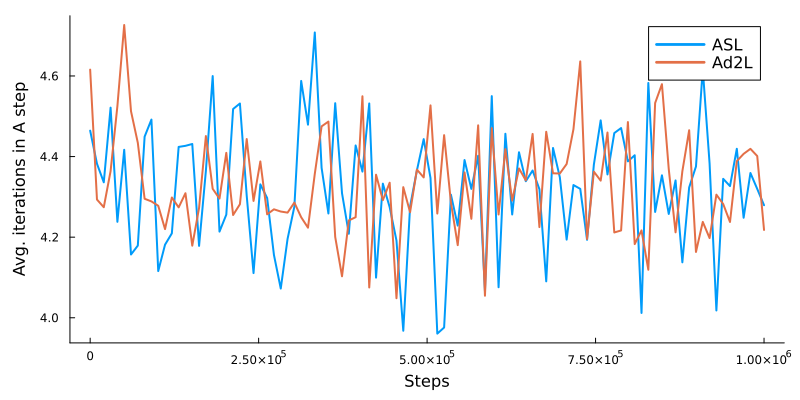

In [89]:
x1 = range(1,1000000,length=100)
reshaped_arr = reshape(s_avg1, 10000, :)
result = mean(reshaped_arr, dims=1)
result1 = vec(result)
reshaped_arr = reshape(s_avg2, 10000, :)
result = mean(reshaped_arr, dims=1)
result2 = vec(result)

plot(size=(800, 400), xlabel="Steps", ylabel="Avg. iterations in A step", legendfontsize=11, grid=false, legend=:topright, 
    bottom_margin=5Plots.mm, left_margin=5Plots.mm, top_margin=2Plots.mm, right_margin=2Plots.mm)
plot!(x1, result1, label="ASL", linewidth=2)
plot!(x1, result2, label="Ad2L", linewidth=2)
# savefig("Avg iterations in A step.pdf")

In [10]:
function plot_density(q_traj, q_pot; linename="linename", plotname="plotname")  # 1d
    x1 = range(minimum(q_traj[1,:]), maximum(q_traj[1,:]), length=1000)
    q1_dist = exp.(-beta*q_pot.(x1)); q1_dist = q1_dist ./ (sum(q1_dist) * (x1[2]-x1[1]))

    q1_plot = stephist(vec(q_traj), bins=1000, normalize=true, label=linename, xlabel="q", ylabel="Density", color="blue")
    plot!(q1_plot, x1, q1_dist, color="red", lw=2, label="True")
    title!(plotname)
    plot(q1_plot, size=(600, 450))
end;

In [29]:
q_force = force_mho; q_pot = pot_mho; q_monitor = monitor_mho; q_monitor_prime = monitor_prime_mho
q0 = randn(1); p0 = randn(1); xi0 = randn()
t = 1000000; h = .3; Nsteps = round(Int, t/h); idx = round(Int, 0.2 * Nsteps) + 1; m = 0.1; M = 1.1
sigma_A = 1.0; mu = 1; beta = 1.0; Nd = 1.; γ = 1.0; beta = 1.0

# initialization
q_traj = zeros(eltype(q0), (4, Nsteps));

# q_traj = run_simulation(q0, p0, Nsteps, h, A, beta, Samples, step_function, grad_U, N, n)
q_traj[1,:], _ = run_Ad_BAOAB(q0, p0, γ, Nsteps, h, beta, m, M, q_force, q_monitor, q_monitor_prime)
q_traj[2,:] = run_BAOAB(q0, p0, γ, Nsteps, h, beta, q_force)
q_traj[3,:], _ = run_Ad_BADODAB(q0, p0, xi0, Nsteps, h, sigma_A, mu, beta, Nd, m, M, q_force, q_monitor, q_monitor_prime)
q_traj[4,:] = run_BADODAB(q0, p0, xi0, Nsteps, h, sigma_A, mu, beta, Nd, q_force)
q_traj = q_traj[:,idx:end];

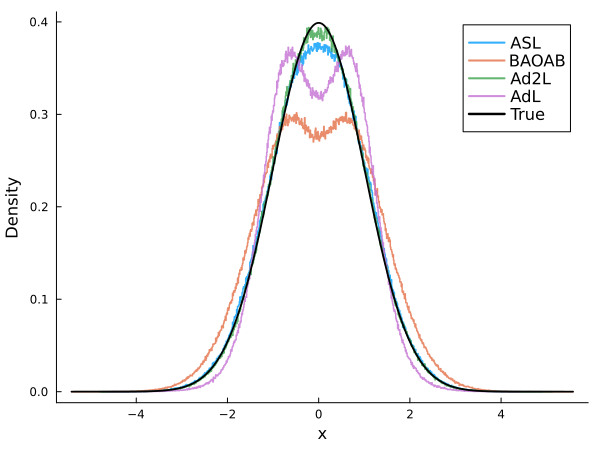

In [32]:
edge = [0.0, 0.0]; edge[1] = minimum(q_traj); edge[2] = maximum(q_traj)
x_standard = range(edge[1], edge[2], length = 1000)
q_dist = pdf.(Normal(0, 1), x_standard)

p_noise = plot(size=(600, 450), xlabel="x", ylabel="Density", legendfontsize=11, grid=false, legend=:topright)
stephist!(p_noise, q_traj[1,:], bins=1000, normalize=:pdf, label="ASL", lw=1.5, alpha=0.8)
stephist!(p_noise, q_traj[2,:], bins=1000, normalize=:pdf, label="BAOAB", lw=1.5, alpha=0.8)
stephist!(p_noise, q_traj[3,:], bins=1000, normalize=:pdf, label="Ad2L", lw=1.5, alpha=0.8)
stephist!(p_noise, q_traj[4,:], bins=1000, normalize=:pdf, label="AdL", lw=1.5, alpha=0.8)
plot!(p_noise, x_standard, q_dist, color=:black, lw=1.8, label="True")
# savefig(p_noise, "Ad2L_noise/noise_distribution2.pdf")

average potential is 0.4619212177917408


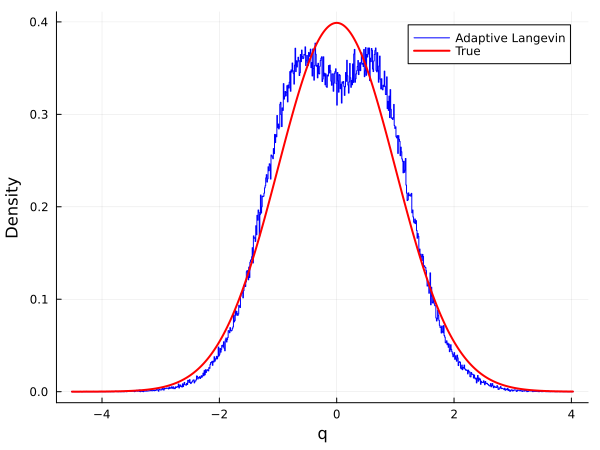

In [108]:
# large gradient noise
q_force = force_mho; q_pot = pot_mho; q_monitor = monitor_mho; q_monitor_prime = monitor_prime_mho
q0 = randn(1); p0 = randn(1); xi0 = randn()
t = 100000; h = .2; Nsteps = round(Int, t/h); idx = round(Int, 0.2 * Nsteps) + 1; m = 0.1; M = 1.5
sigma_A = 1.0; mu = 1; beta = 1.0; Nd = 1.; γ = 1.0; beta = 1.0

q_traj = run_BADODAB(q0, p0, xi0, Nsteps, h, sigma_A, mu, beta, Nd, q_force);
q_traj = q_traj[:,idx:end]

pot_avg = sum(q_pot.(q_traj) .* h) / t/0.8
println("average potential is $pot_avg")
plot_density(q_traj, q_pot, linename="Adaptive Langevin", plotname="")

average of monitor is 0.2780339065627058
average potential is 0.5246594732785165


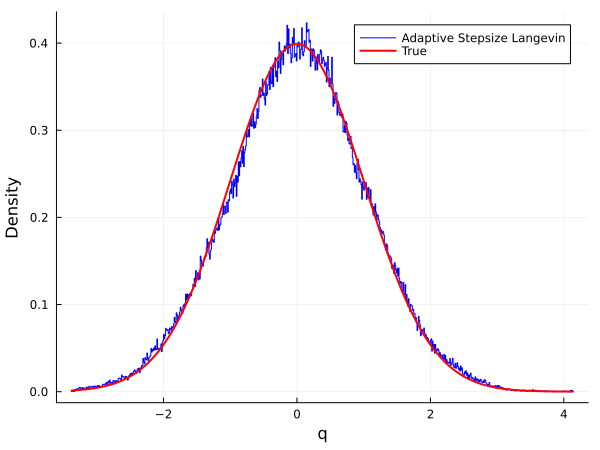

In [109]:
q_traj, g_avg = run_Ad_BAOAB(q0, p0, γ, Nsteps, h, beta, m, M, q_force, q_monitor, q_monitor_prime)
q_traj = q_traj[:,idx:end]

pot_avg = sum(q_pot.(q_traj) .* h) / t/0.8
println("average of monitor is $g_avg")
println("average potential is $pot_avg")
plot_density(q_traj, q_pot, linename="Adaptive Stepsize Langevin", plotname="")

average potential is 0.6367696408538116


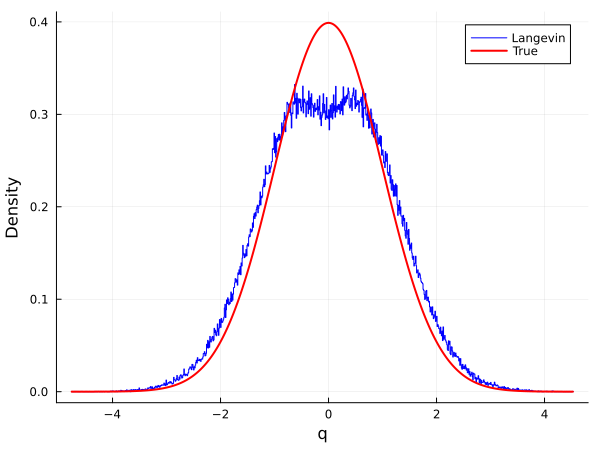

In [110]:
q_traj = run_BAOAB(q0, p0, γ, Nsteps, h, beta, q_force);
q_traj = q_traj[:,idx:end]

pot_avg = sum(q_pot.(q_traj) .* h) / t/0.8
println("average potential is $pot_avg")
plot_density(q_traj, q_pot, linename="Langevin", plotname="")

average of monitor is 0.28156906901204276
average potential is 0.5023006358225609


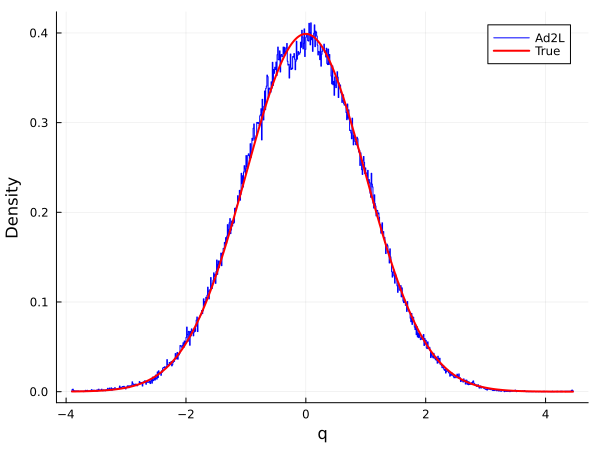

In [111]:
q_traj, g_avg = run_Ad_BADODAB(q0, p0, xi0, Nsteps, h, sigma_A, mu, beta, Nd, m, M, q_force, q_monitor, q_monitor_prime);
q_traj = q_traj[:,idx:end]

pot_avg = sum(q_pot.(q_traj) .* h) / t/0.8
println("average of monitor is $g_avg")
println("average potential is $pot_avg")
plot_density(q_traj, q_pot, linename="Ad2L", plotname="")

### Steep Potential

In [7]:
# Initialize one walker from a Gaussian distribution
dim = 1; q0 = randn(dim); p0 = randn(dim); xi0 = randn()
t = 1000000; h = .3; Nsteps = round(Int, t/h); idx = round(Int, 0.2 * Nsteps) + 1; m = 0.1; M = 1.1
sigma_A = 1.0; mu = 1; beta = 1.0; Nd = 1.; γ = 1.0
q_pot = pot_V; q_force = force_V; q_monitor = omega; q_monitor_prime = omega_prime

epsilon = 1; r = 0.8; λ = 50    # λ_lst = [1, 3, 50]  Weibull: using k=λ to keep the scale
Gaussian_noise = (1-r)*Normal()
Weibull_mean = λ * gamma(1 + 1/λ)
Weibull_noise = r * (Weibull(λ, λ) .- Weibull_mean)

# initialization
q_traj = zeros(eltype(q0), (4, Nsteps));

# q_traj = run_simulation(q0, p0, Nsteps, h, A, beta, Samples, step_function, grad_U, N, n)
q_traj[1,:], _ = run_Ad_BAOAB(q0, p0, γ, Nsteps, h, beta, m, M, q_force, q_monitor, q_monitor_prime, epsilon*Weibull_noise, epsilon*Gaussian_noise)
q_traj[2,:] = run_BAOAB(q0, p0, γ, Nsteps, h, beta, q_force, epsilon*Weibull_noise, epsilon*Gaussian_noise)
q_traj[3,:], _ = run_Ad_BADODAB(q0, p0, xi0, Nsteps, h, sigma_A, mu, beta, Nd, m, M, q_force, q_monitor, q_monitor_prime, epsilon*Weibull_noise, epsilon*Gaussian_noise)
q_traj[4,:] = run_BADODAB(q0, p0, xi0, Nsteps, h, sigma_A, mu, beta, Nd, q_force, epsilon*Weibull_noise, epsilon*Gaussian_noise)
q_traj = q_traj[:,idx:end];

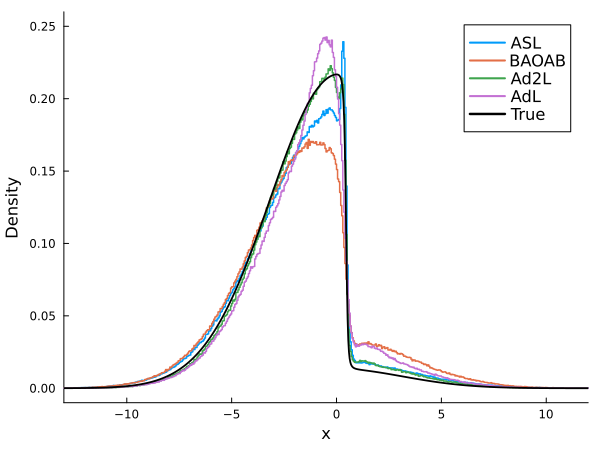

In [8]:
edge = [0.0, 0.0]; edge[1] = minimum(q_traj); edge[2] = maximum(q_traj)
x_standard = range(edge[1], edge[2], length = 1000)
# q_dist = pdf.(Normal(0, 1), x_standard)
q_dist = exp.(-beta*q_pot.(x_standard)); q_dist = q_dist ./ (sum(q_dist) * (x_standard[2] - x_standard[1]))

p_noise = plot(size=(600, 450), xlabel="x", ylabel="Density", legendfontsize=11, grid=false, legend=:topright, xlims=(-13, 12), ylims=(-0.01, 0.26))
stephist!(p_noise, q_traj[1,:], bins=1000, normalize=:pdf, label="ASL", lw=1.5, alpha=1)
stephist!(p_noise, q_traj[2,:], bins=1000, normalize=:pdf, label="BAOAB", lw=1.5, alpha=1)
stephist!(p_noise, q_traj[3,:], bins=1000, normalize=:pdf, label="Ad2L", lw=1.5, alpha=1)
stephist!(p_noise, q_traj[4,:], bins=1000, normalize=:pdf, label="AdL", lw=1.5, alpha=1)
plot!(p_noise, x_standard, q_dist, color=:black, lw=1.8, label="True")
# savefig(p_noise, "Ad2L_steep/steep_distribution_λ=$λ.pdf")

average of monitor is 1.0199708942574526
average potential is -0.6747472535416932


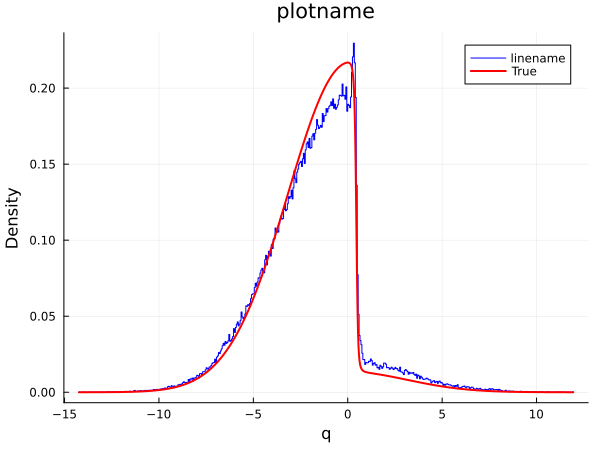

In [140]:
# Initialize one walker from a Gaussian distribution
dim = 1; q0 = randn(dim); p0 = randn(dim); xi0 = randn()
t = 100000; h = .3; Nsteps = round(Int, t/h); idx = round(Int, 0.2 * Nsteps) + 1; m = 0.1; M = 1.1
sigma_A = 1.0; mu = 1; beta = 1.0; Nd = 1.; γ = 1.0
q_pot = pot_V; q_force = force_V; q_monitor = omega; q_monitor_prime = omega_prime

epsilon = 1.0; r = 0.8; λ = 1    # λ_lst = [1, 3, 50]  Weibull: using k=λ to keep the scale
Gaussian_noise = (1-r)*Normal()
Weibull_mean = λ * gamma(1 + 1/λ)
Weibull_noise = r * (Weibull(λ, λ) .- Weibull_mean)

q_traj, g_avg = run_Ad_BAOAB(q0, p0, γ, Nsteps, h, beta, m, M, q_force, q_monitor, q_monitor_prime, epsilon*Weibull_noise, epsilon*Gaussian_noise)
q_traj = q_traj[:,idx:end]

pot_avg = sum(q_pot.(q_traj) .* h) / t/0.8
println("average of monitor is $g_avg")
println("average potential is $pot_avg")
plot_density(q_traj, q_pot)

average potential is -0.5071141800128944


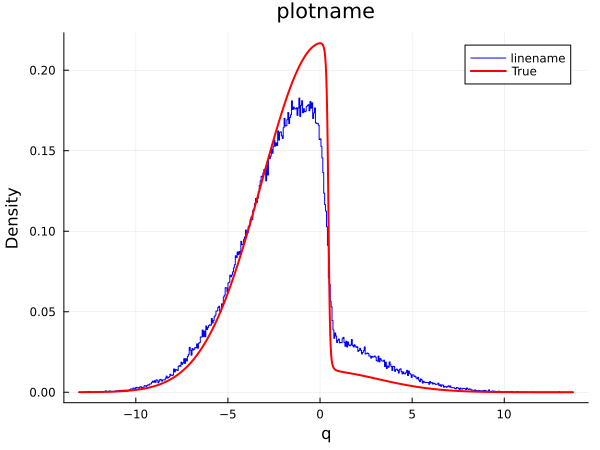

In [141]:
q_traj = run_BAOAB(q0, p0, γ, Nsteps, h, beta, q_force, epsilon*Weibull_noise, epsilon*Gaussian_noise);
q_traj = q_traj[:,idx:end]

pot_avg = sum(q_pot.(q_traj) .* h) / t/0.8
println("average potential is $pot_avg")
plot_density(q_traj, q_pot)

MAE is 0.0022440504180999865
average of monitor is 1.0284596958477286
average potential is -0.739814634014942


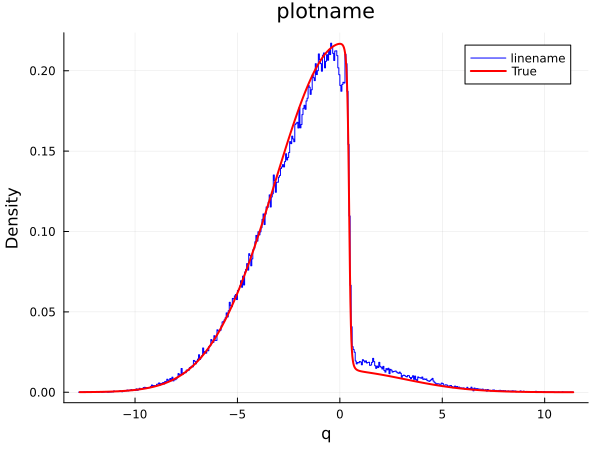

In [121]:
q_traj, g_avg = run_Ad_BADODAB(q0, p0, xi0, Nsteps, h, sigma_A, mu, beta, Nd, m, M, q_force, q_monitor, q_monitor_prime, epsilon*Weibull_noise, epsilon*Gaussian_noise);
q_traj = q_traj[:,idx:end]

pot_avg = sum(q_pot.(q_traj) .* h) / t/0.8
println("average of monitor is $g_avg")
println("average potential is $pot_avg")
plot_density(q_traj, q_pot)

average potential is -0.6671744316351037


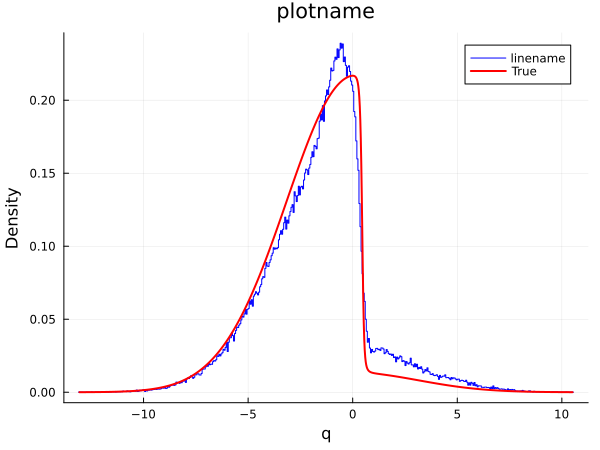

In [142]:
q_traj = run_BADODAB(q0, p0, xi0, Nsteps, h, sigma_A, mu, beta, Nd, q_force, epsilon*Weibull_noise, epsilon*Gaussian_noise);
q_traj = q_traj[:,idx:end]

pot_avg = sum(q_pot.(q_traj) .* h) / t/0.8
println("average potential is $pot_avg")
plot_density(q_traj, q_pot)

In [9]:
using QuadGK
q_pot = pot_V
f(x) = q_pot(x) * exp(-q_pot(x))
g(x) = exp(-q_pot(x))
result1, error1 = quadgk(x -> f(x), -Inf, Inf)
result2, error2 = quadgk(x -> g(x), -Inf, Inf)
obs = result1 / result2

-0.8054779535405598

### Harmonic oscillator

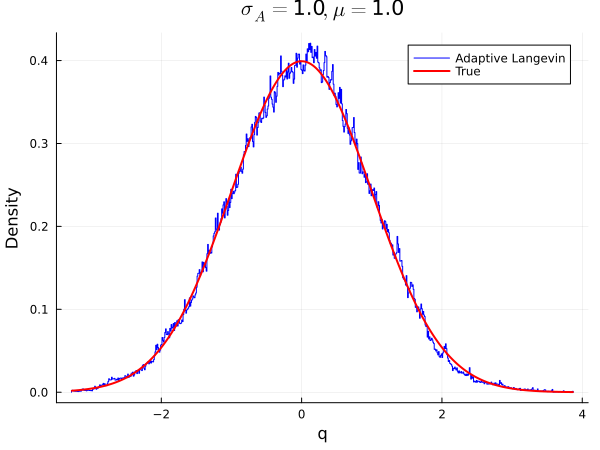

In [12]:
# Initialize one walker from a Gaussian distribution
q0 = randn(1); p0 = randn(1); xi0 = randn()

t = 10000; h = .01; Nsteps = round(Int, t/h)
sigma_A = 1.0; mu = 1.0; beta = 1.0; Nd = 1.; idx = round(Int, 0.2 * Nsteps) + 1; q_force = force_ho

# Run one long trajectory of Nsteps
q_traj = run_BADODAB(q0, p0, xi0, Nsteps, h, sigma_A, mu, beta, Nd, q_force);
q_traj = q_traj[:,idx:end]

plot_density(q_traj, pot_ho)
title!(L"\sigma_A=" * "$(sigma_A)" * L", \mu=" * "$mu")

In [13]:
sum(pot_ho.(q_traj) .* h) / t/0.8

0.4948655261326371

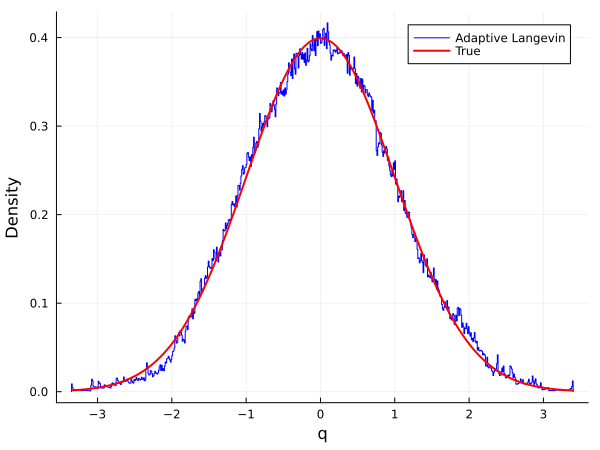

In [22]:
# Initialize one walker from a Gaussian distribution
q0 = randn(1); p0 = randn(1); xi0 = randn()

t = 10000; h = .01; Nsteps = round(Int, t/h); m = 0.01; M = 1.5
γ = 1.0; beta = 1.0; idx = round(Int, 0.2 * Nsteps) + 1; 
q_pot = pot_ho; q_force = force_ho; q_monitor = x -> norm(q_force(x)); q_monitor_prime = x -> x / q_monitor(x)

# Run one long trajectory of Nsteps
# q_traj = run_Ad_BAOAB(q0, p0, γ, Nsteps, h, beta, m, M, q_force, q_monitor, q_monitor_prime)
q_traj, p_traj, g_avg = run_Ad_BAOAB(q0, p0, γ, Nsteps, h, beta, m, M, q_force, q_monitor, q_monitor_prime)
q_traj = q_traj[:,idx:end]

plot_density(q_traj, pot_ho)

In [23]:
g_avg

0.8873300024545642

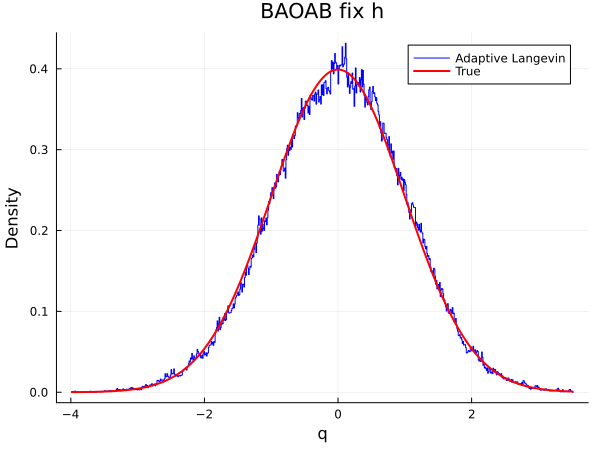

In [18]:
γ = 1.;
q_traj = run_BAOAB(q0, p0, γ, Nsteps, h, beta, q_force);
q_traj = q_traj[:,idx:end]

plot_density(q_traj, pot_ho)
title!("BAOAB fix h")

In [20]:
sum(pot_ho.(q_traj) .* h) / t / 0.8

0.5015100937104169

average of monitor is 0.8885371233948683
average potential is 0.5010427070571105


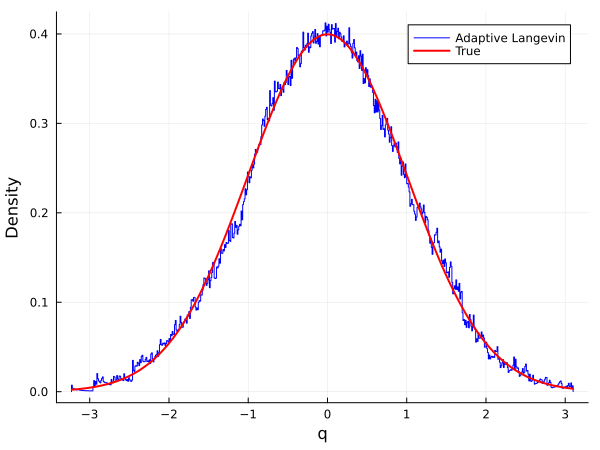

In [24]:
q_traj, p_traj, g_avg = run_Ad_BADODAB(q0, p0, xi0, Nsteps, h, sigma_A, mu, beta, Nd, m, M, q_force, q_monitor, q_monitor_prime);
q_traj = q_traj[:,idx:end]

pot_avg = sum(q_pot.(q_traj) .* h) / t/0.8
println("average of monitor is $g_avg")
println("average potential is $pot_avg")
plot_density(q_traj, q_pot)

### Another potential

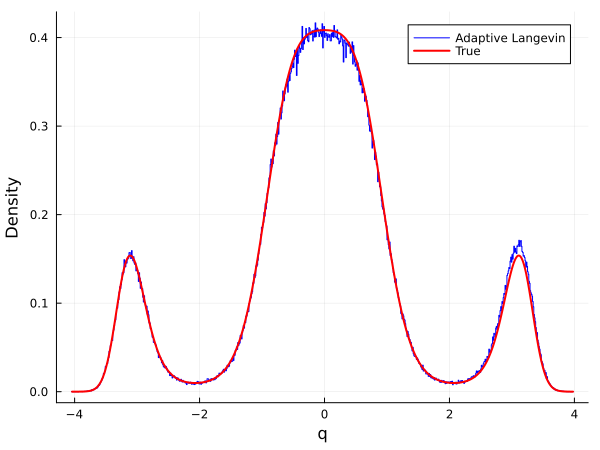

In [ ]:
# Initialize one walker from a Gaussian distribution
q0 = randn(1); p0 = randn(1); xi0 = randn()

Nsteps = 1000000; h = .1
sigma_A = 1.0; mu = 1.0; beta = 1.0; Nd = 1.0
# sigma_A = 0.0; mu = 1.0; beta = Inf; Nd = 1.

# Run one long trajectory of Nsteps
q_traj = run_BADODAB(q0, p0, xi0, Nsteps, h, sigma_A, mu, beta, Nd, my_force);
# q_traj, p_traj, xi_traj, t_traj = run_PAD(q0, p0, xi0, Nsteps, h, sigma_A, mu, beta, Nd, my_force);

plot_density(q_traj, my_pot)

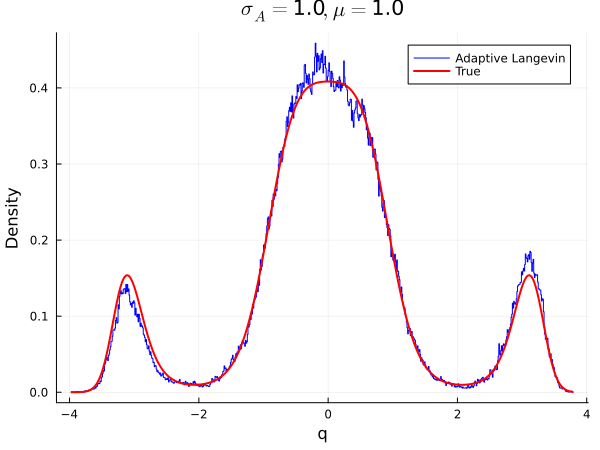

In [27]:
γ = 1.; tol = 1e-3; k = 0.1
q_traj, p_traj, h_traj = run_Ad_BAOAB(q0, p0, γ, Nsteps, h, beta, my_force, tol, k);
q_traj = q_traj[:,idx:end]; h_traj = h_traj[idx:end]

plot_density(q_traj, my_pot, h_traj)
title!(L"\sigma_A=" * "$(sigma_A)" * L", \mu=" * "$mu")

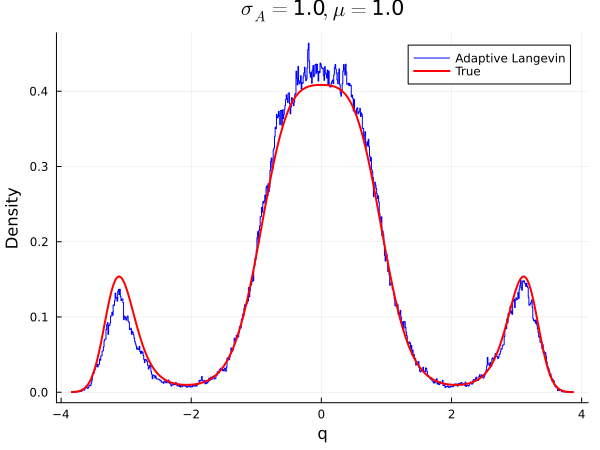

In [24]:
γ = 1.; tol = 1e-3; k = 0.1
q_traj = run_BAOAB(q0, p0, γ, Nsteps, h, beta, my_force);
q_traj = q_traj[:,idx:end]

plot_density(q_traj, my_pot)
title!(L"\sigma_A=" * "$(sigma_A)" * L", \mu=" * "$mu")

#### noisy force

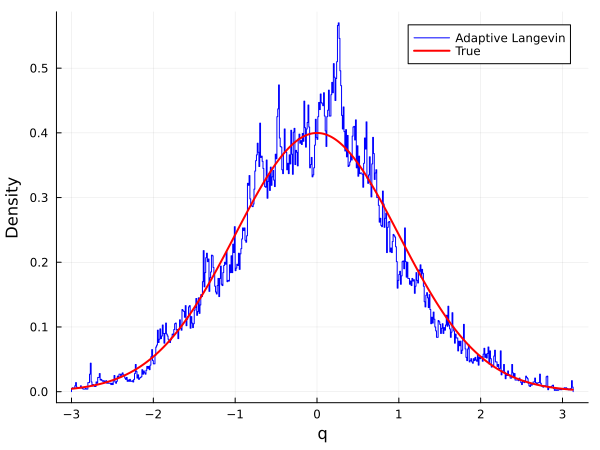

In [ ]:
sigma_A = 1.0; mu = 1.0; beta = 1.0; Nd = 1.0; 
α = 1.5; epsilon = 1; λ = 10.0
Weibull_mean = λ * gamma(1 + 1/λ)
Weibull_noise = Weibull(λ, λ) .- Weibull_mean

# Run one long trajectory of Nsteps
Nsteps = 100000
q_traj = run_BADODAB(q0, p0, xi0, Nsteps, h, sigma_A, mu, beta, Nd, force_hc, epsilon*Weibull_noise, Normal());

plot_density(q_traj, pot_hc)

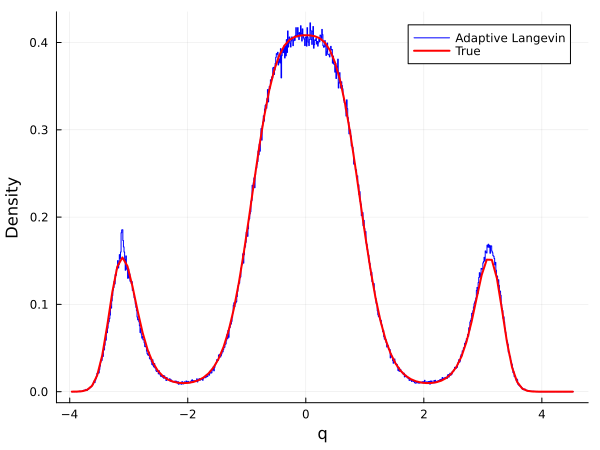

In [ ]:
sigma_A = 1.0; mu = 1.0; beta = 1.0; Nd = 1.0; 
α = 1.5; epsilon = 0.1; 

q_traj, p_traj, xi_traj, t_traj = run_BADODAB(q0, p0, xi0, Nsteps, h, sigma_A, mu, beta, Nd, my_force, epsilon * Stable(α));

plot_density(q_traj, my_pot)

-0.0011326510508352793


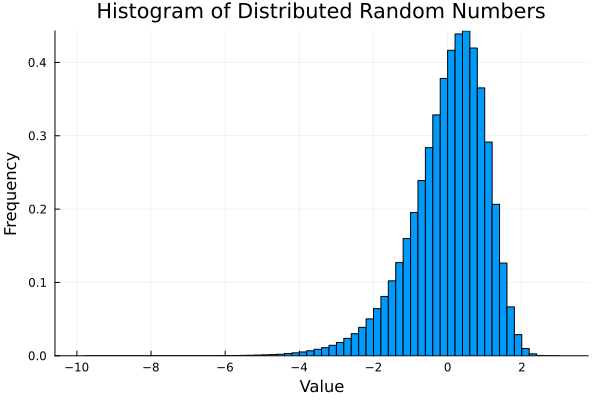

In [ ]:
# ratio of a distribution
r = 0.8

# Set the parameters for the stable distribution
α = 1.5  # Stability parameter, range 0 < α ≤ 2
λ = 100; k = λ  # Weibull scale & shape parameter: λ, k > 0 (shape 1~3)

# Create a stable distribution
dist0 = Normal()  # background noise
# dist = Stable(α)
dist = Weibull(k, λ); mean_weibull = λ * gamma(1 + 1/k); dist = dist .- mean_weibull

# Generate random numbers from the stable distribution
n = 1000000  # Number of random samples to generate
samples = (1 - r) * rand(dist0, n) + r * rand(dist, n)

# Print the mean of generated random samples
println(mean(samples))

# Generate a histogram
histogram(samples, bins=100, title="Histogram of Distributed Random Numbers", normalize=true, xlabel="Value", ylabel="Frequency", legend=false)


-0.0008009579998428147


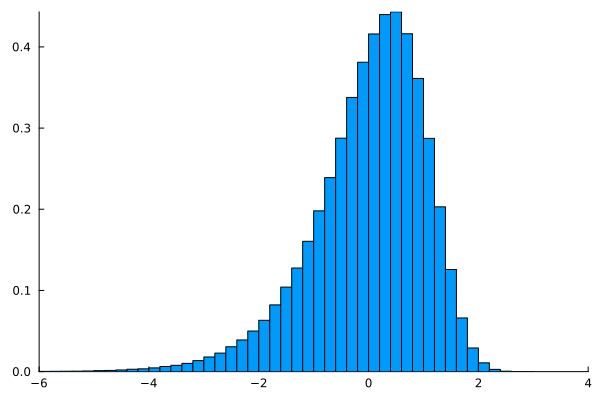

In [11]:
# ratio of a distribution
r = 0.8

# Set the parameters for the stable distribution
α = 1.5  # Stability parameter, range 0 < α ≤ 2
λ = 50; k = λ  # Weibull scale & shape parameter: λ, k > 0 (shape 1~3)

# Create a stable distribution
dist0 = (1 - r) * Normal()  # background noise
# dist = Stable(α)
dist = Weibull(k, λ); mean_weibull = λ * gamma(1 + 1/k); dist = dist .- mean_weibull
dist = r * dist

# Generate random numbers from the stable distribution
n = 1000000  # Number of random samples to generate
samples = rand(dist0, n) + rand(dist, n)

# Print the mean of generated random samples
println(mean(samples))

# Generate a histogram
histogram(samples, bins=100, normalize=true, legend=false, grid=false, xlims=(-6,4))
# savefig("$r Weibull noise with λ = $λ.pdf")

In [12]:
savefig("$r Weibull noise with λ = $λ.pdf")

"e:\\OneDrive - University of Edinburgh\\MATH11195 Dissertation\\code\\0.8 Weibull noise with λ = 50.pdf"